*Based in part on Patrick Maher's "Sports Body Types" analysis (https://github.com/pmaher86/sports-body-types)
and Eytan Adar's EDA Classification Lab (2016).*

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# Load NBA player stats

In [2]:
nba_frame = pd.DataFrame.from_csv('NBA stats.csv')
nba_frame.head()

,height,name,position,weight
0,80,Brandon Bass,PF,250
1,74,Avery Bradley,PG,180
2,78,Jae Crowder,SF,235
3,81,Jeff Green,SF,235
4,72,Jameer Nelson,PG,190


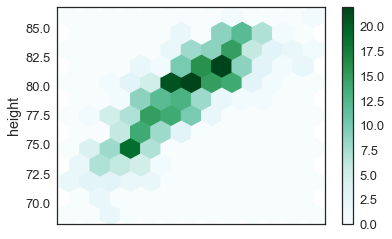

In [3]:
nba_frame.plot(x='weight',y='height', kind='hexbin', gridsize=12)

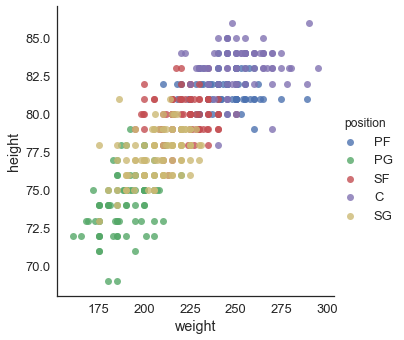

In [4]:
sns.lmplot(x='weight', y='height', hue='position', 
           fit_reg=False, data=nba_frame);

# K-Means

In [5]:
nba_hw_frame = nba_frame[['height', 'weight']]

In [6]:
kmeans_model = skc.KMeans(n_clusters=5)
kmeans_model.fit(nba_hw_frame)
centroids = kmeans_model.cluster_centers_
centroids  # these are the centers of the clusters

array([[  79.92372881,  222.83050847],
       [  82.        ,  244.74789916],
       [  74.41791045,  182.91044776],
       [  76.94736842,  203.66315789],
       [  82.68421053,  268.68421053]])

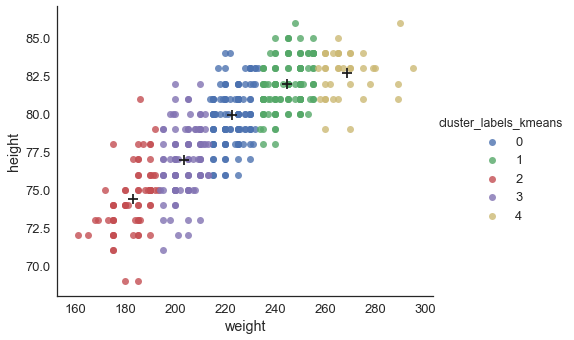

In [7]:
# Plot the clusters with their centroids.
pd.options.mode.chained_assignment = None  # default='warn'
nba_hw_frame['cluster_labels_kmeans'] = kmeans_model.labels_
f = sns.lmplot(x='weight', y='height', data=nba_hw_frame, hue='cluster_labels_kmeans',
               fit_reg=False, size=5, aspect=1.3)
f.ax.scatter(centroids[:,1], centroids[:,0], marker='+', s=100,
             linewidths=2, color='k')

Here's the original data as a reminder

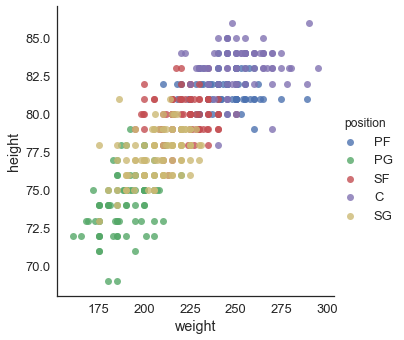

In [8]:
sns.lmplot(x='weight', y='height', hue='position', 
           fit_reg=False, data=nba_frame) #, size=10, aspect=1.3, scatter_kws={"s": 100})

# K-Nearest Neighbors
Let's use the existing NBA player data to try to classify player positions based on height and weight.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
n = 5  # How many neighbours to use

In [11]:
nba_neigh = KNeighborsClassifier(n_neighbors=n)
nba_neigh.fit(nba_frame[['weight','height']],nba_frame['position'])
nba_neigh_predictions = nba_neigh.predict(nba_frame[['weight','height']])

Now we can try it on a few possible players.

In [12]:
shaq = np.array([[325,85]]) #listed weight/height from when he played (he isn't in the dataset)
print(nba_neigh.predict(shaq))  #he played center

['C']


In [13]:
wes = np.array([[185,76]])  #I've definitely never played
print(nba_neigh.predict(wes))

['PG']


In [14]:
lebron = np.array([[250,80]]) #current listed weight/height
print(nba_neigh.predict(lebron))  #he plays at small forward

['PF']


In [15]:
nba_frame[nba_frame['name'] == 'LeBron James']

,height,name,position,weight
164,80,LeBron James,SF,250


^ KNN actually got this wrong, even though LeBron is in the dataset. (Try some other numbers of neighbors and see how that changes things.)

#### All classifications
We can actually check to see how our classifier would label ANY height/weight combination just by testing and plotting a whole bunch of values.

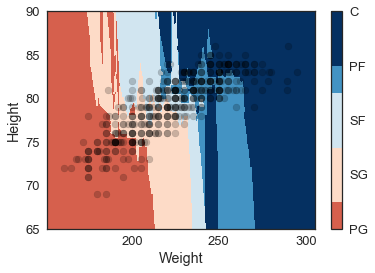

In [16]:

def plot_height_weight_pos(df, classifier, npts=500): #500x500 points will look smooth but take a few seconds
    xx,yy=np.meshgrid(np.linspace(df['weight'].min()-10,df['weight'].max()+10,num=npts), 
                      np.linspace(df['height'].min()-4,df['height'].max()+4,num=npts))
    Zstring = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    repdict = {'PG':1,'SG':2,'SF':3,'PF':4,'C':5} #map predictions to plottable numbers
    Z = np.zeros_like(Zstring)
    for k,v in repdict.items():
        Z[Zstring==k]=v
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('RdBu',6),vmin=0,vmax=5)
    plt.xlabel('Weight');plt.ylabel('Height')
    cbar = plt.colorbar(ticks=[1,2,3,4,5])
    cbar.ax.set_yticklabels(['PG', 'SG', 'SF', 'PF', 'C'])
    plt.scatter(df['weight'],df['height'], color="black",alpha=0.2)
    
plot_height_weight_pos(nba_frame,nba_neigh)


# Naive Bayes 

In [17]:
from sklearn.naive_bayes import GaussianNB
nba_gnb = GaussianNB().fit(nba_frame[['weight','height']],nba_frame['position'])
nba_gnb_predictions = nba_gnb.predict(nba_frame[['weight','height']])

In [18]:
print(nba_gnb.predict(shaq))

['C']


In [19]:
print(nba_gnb.predict(lebron))

['PF']


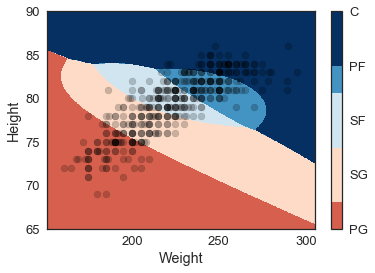

In [20]:
plot_height_weight_pos(nba_frame,nba_gnb)

# Evaluating Classification Performance
There are a number of scores and plots that we can compute or generate to evaluate classification results. We will introduce the following techniques:
- Accuracy
- Precision
- Recall
- F1 score
- Confusion Matrix

First, lets try actually getting a test sample.

In [22]:
from random import randint
hw_train, hw_test, pos_train, pos_test = sk.model_selection.train_test_split(
    nba_frame[['weight','height']],nba_frame['position'], test_size=0.4, random_state=randint(0,1000))

In [23]:
nba_gnb_test = GaussianNB().fit(hw_train,pos_train)
nba_gnb_predictions_test = nba_gnb.predict(hw_test)

In [24]:
#Accuracy
skm.accuracy_score(y_true=pos_test,
                   y_pred=nba_gnb_predictions_test)

0.67428571428571427

In [25]:
# Precision
skm.precision_score(y_true=pos_test,
                    y_pred=nba_gnb_predictions_test,
                    average='weighted')

0.6846052150345141

In [26]:
# Recall
skm.recall_score(y_true=pos_test,
                 y_pred=nba_gnb_predictions_test,
                 average='weighted')

0.67428571428571427

In [27]:
# F1 Score
skm.f1_score(y_true=pos_test,
             y_pred=nba_gnb_predictions_test,
             average='weighted')

0.67618090051269775

In [28]:
# Compute the confusion matrix
nba_neigh_cfmat = skm.confusion_matrix(
    y_true=pos_test,
    y_pred=nba_gnb_predictions_test,)
nba_neigh_cfmat

array([[29, 10,  0,  0,  0],
       [ 9, 17,  0,  9,  0],
       [ 0,  0, 30,  0,  5],
       [ 0,  4,  0, 17,  5],
       [ 0,  0,  5, 10, 25]], dtype=int64)

Text(0.5,1,'Confusion Matrix')

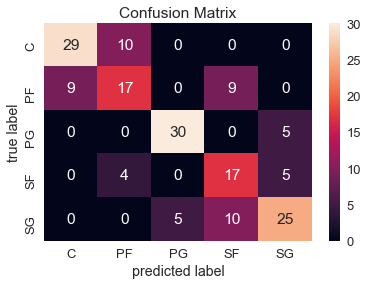

In [29]:
# Visualize the confusion matrix
sns.heatmap(nba_neigh_cfmat, 
            xticklabels=nba_neigh.classes_,
            yticklabels=nba_neigh.classes_,
            annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')


Text(0.5,1,'Confusion Matrix')

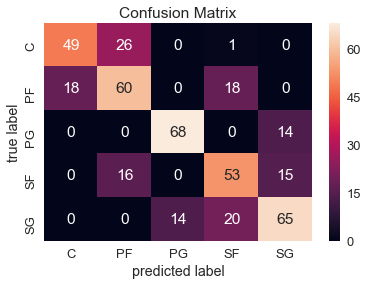

In [30]:
# For comparison, here's the confusion matrix for our original Naive Bayes classifier
nba_gnb_cfmat = skm.confusion_matrix(
    y_true=nba_frame['position'],
    y_pred=nba_gnb_predictions)
nba_gnb_cfmat

sns.heatmap(nba_gnb_cfmat, 
            xticklabels=nba_gnb.classes_,
            yticklabels=nba_gnb.classes_,
            annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')